In [ ]:
# import the libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline 
import matplotlib as mpl

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

mpl.style.use(['ggplot'])

In [ ]:
# load the dataset into dataframe
df = pd.read_csv('honda_sell_data.csv')
df.head(5)

,Year,Make,Model,Condition,Price,Consumer_Rating,Consumer_Review_#,Exterior_Color,Interior_Color,Drivetrain,...,Stock_#,Mileage,Comfort_Rating,Interior_Design_Rating,Performance_Rating,Value_For_Money_Rating,Exterior_Styling_Rating,Reliability_Rating,State,Seller_Type
0,2023,Honda,Ridgeline RTL,New,"$46,370",4.8,9,Platinum White Pearl,Beige,All-wheel Drive,...,00830164,10,5.0,4.8,4.8,4.2,5.0,5.0,CA,Dealer
1,2023,Honda,CR-V Hybrid Sport,New,"$34,150",1.7,24,Platinum White Pearl,Black,FWD,...,6402953,–,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
2,2023,Honda,CR-V Hybrid Sport,New,"$34,245",4.7,2869,Meteorite Gray Metallic,Black,Front-wheel Drive,...,PH704805,1,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
3,2022,Honda,Pilot TrailSport,New,"$46,500",5.0,12,Sonic Gray Pearl,Black,All-wheel Drive,...,5700429B,5,5.0,5.0,5.0,5.0,5.0,5.0,CA,Dealer
4,2023,Honda,CR-V Hybrid Sport Touring,New,"$40,395",4.4,12,Crystal Black Pearl,Black,All-wheel Drive,...,5705954,5,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer


In [ ]:
# check the available feautures in dataset and the size
print('Dataset size:',df.shape)
print('Available features:',', '.join(list(df.columns)))

Dataset size: (4999, 25)
Available features: Year, Make, Model, Condition, Price, Consumer_Rating, Consumer_Review_#, Exterior_Color, Interior_Color, Drivetrain, MPG, Fuel_Type, Transmission, Engine, VIN, Stock_#, Mileage, Comfort_Rating, Interior_Design_Rating, Performance_Rating, Value_For_Money_Rating, Exterior_Styling_Rating, Reliability_Rating, State, Seller_Type


<ipython-input-115-a00b00b6ba75>:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


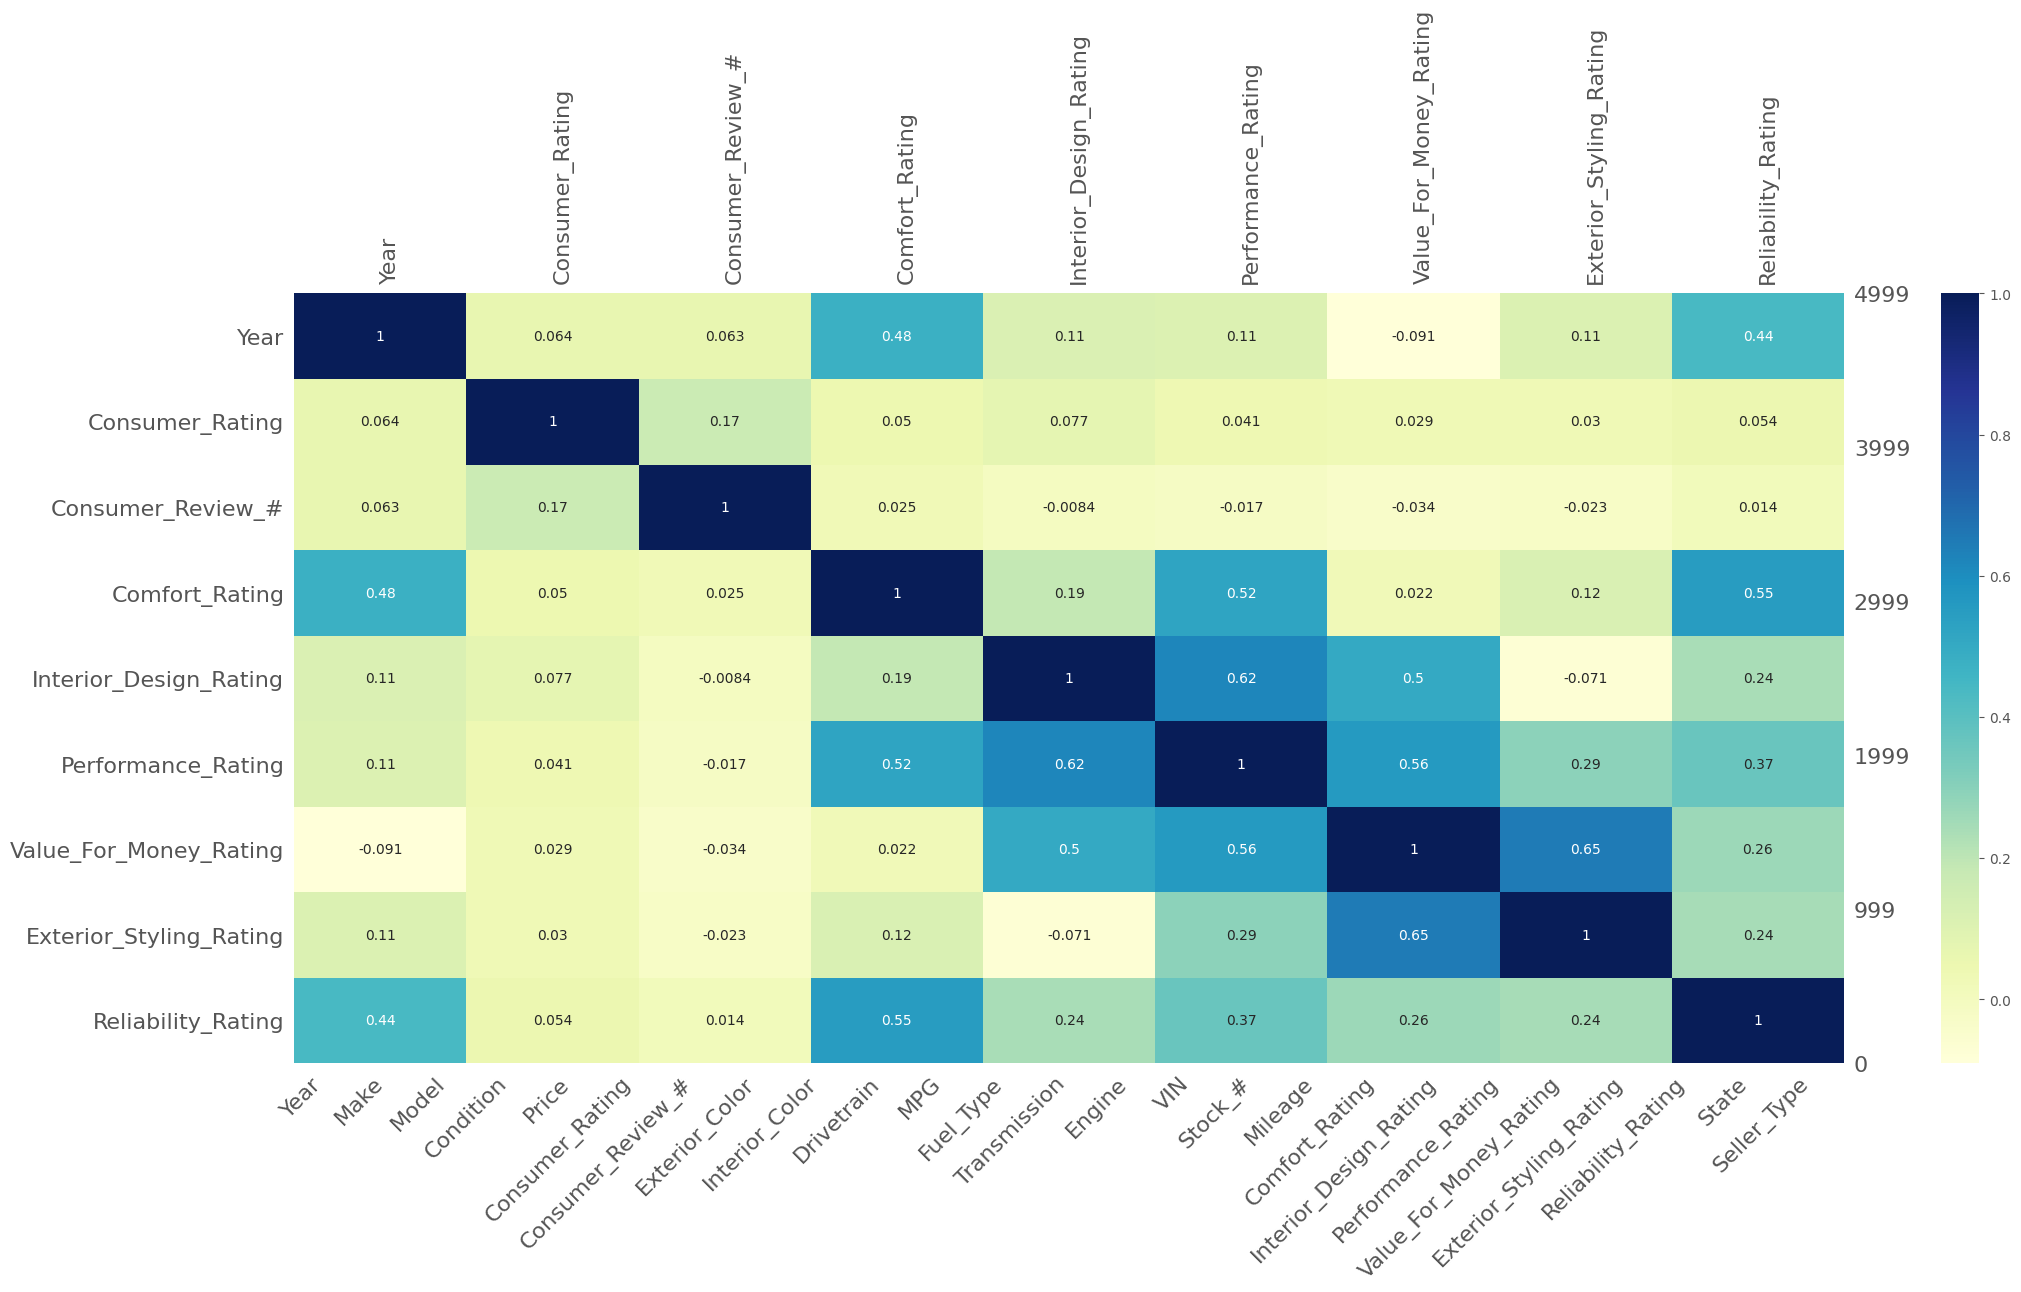

In [ ]:
# check the stats of each features
missing = df.isnull().sum()
unique = df.nunique()
types = df.dtypes
count = len(df)

output = pd.DataFrame({
    'variable': df.columns, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
})

output = output.sort_values("missing",ascending=False).reset_index(drop=True)

# visulaize missing values count for each variable
msno.bar(df)

# visulaize the correlation between missing values in each variable
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

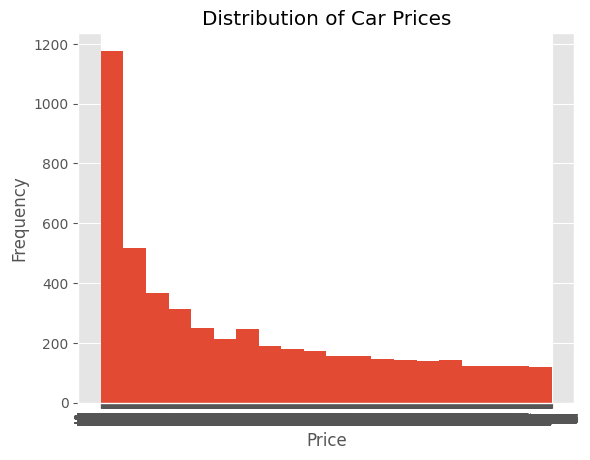

In [ ]:
# Visualize the distribution of car prices
plt.hist(df['Price'], bins=20)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices')
plt.show()

<ipython-input-117-6fd171f2dd3c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


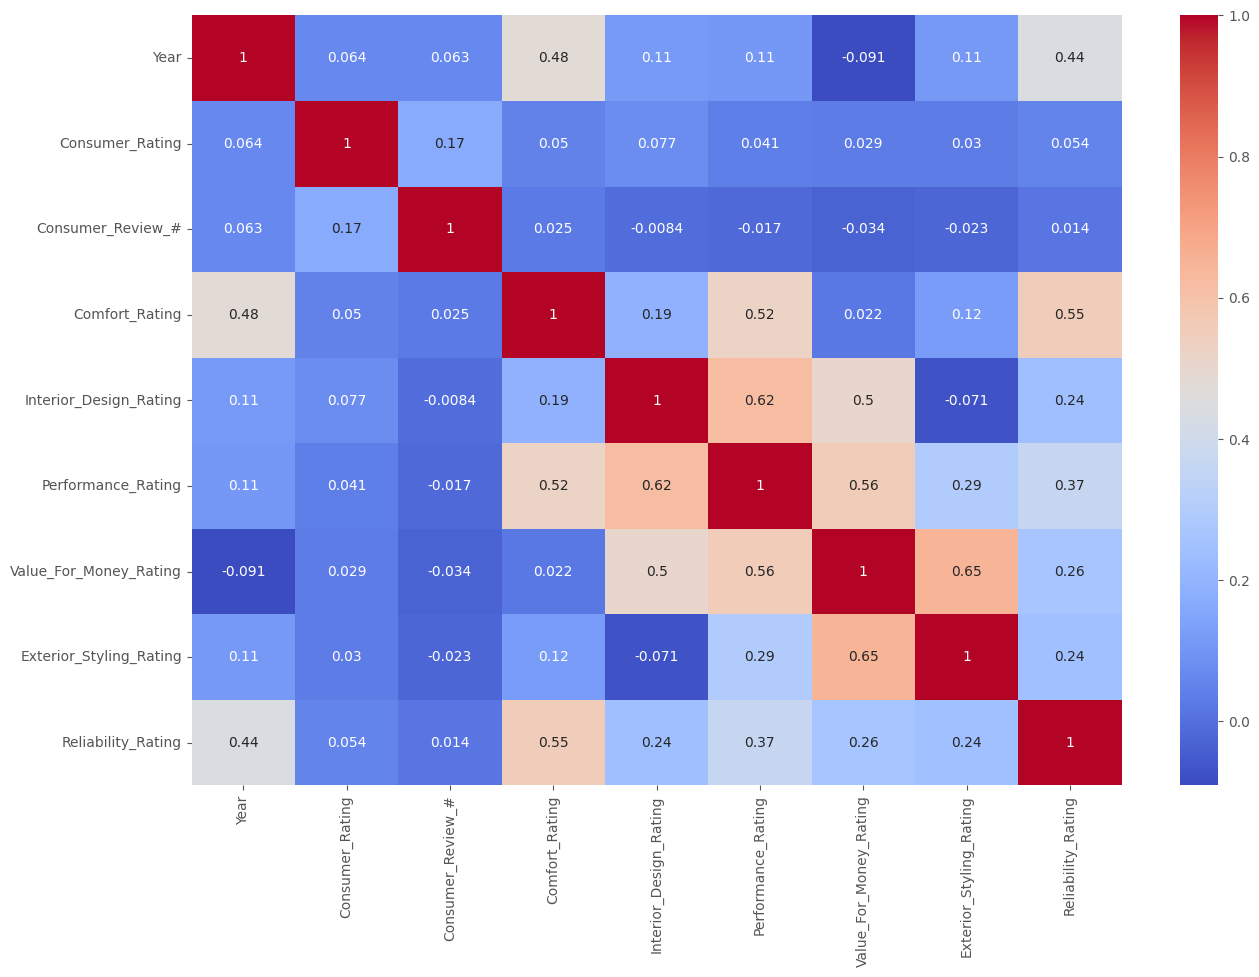

In [ ]:
# Visualize the correlation between variables
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

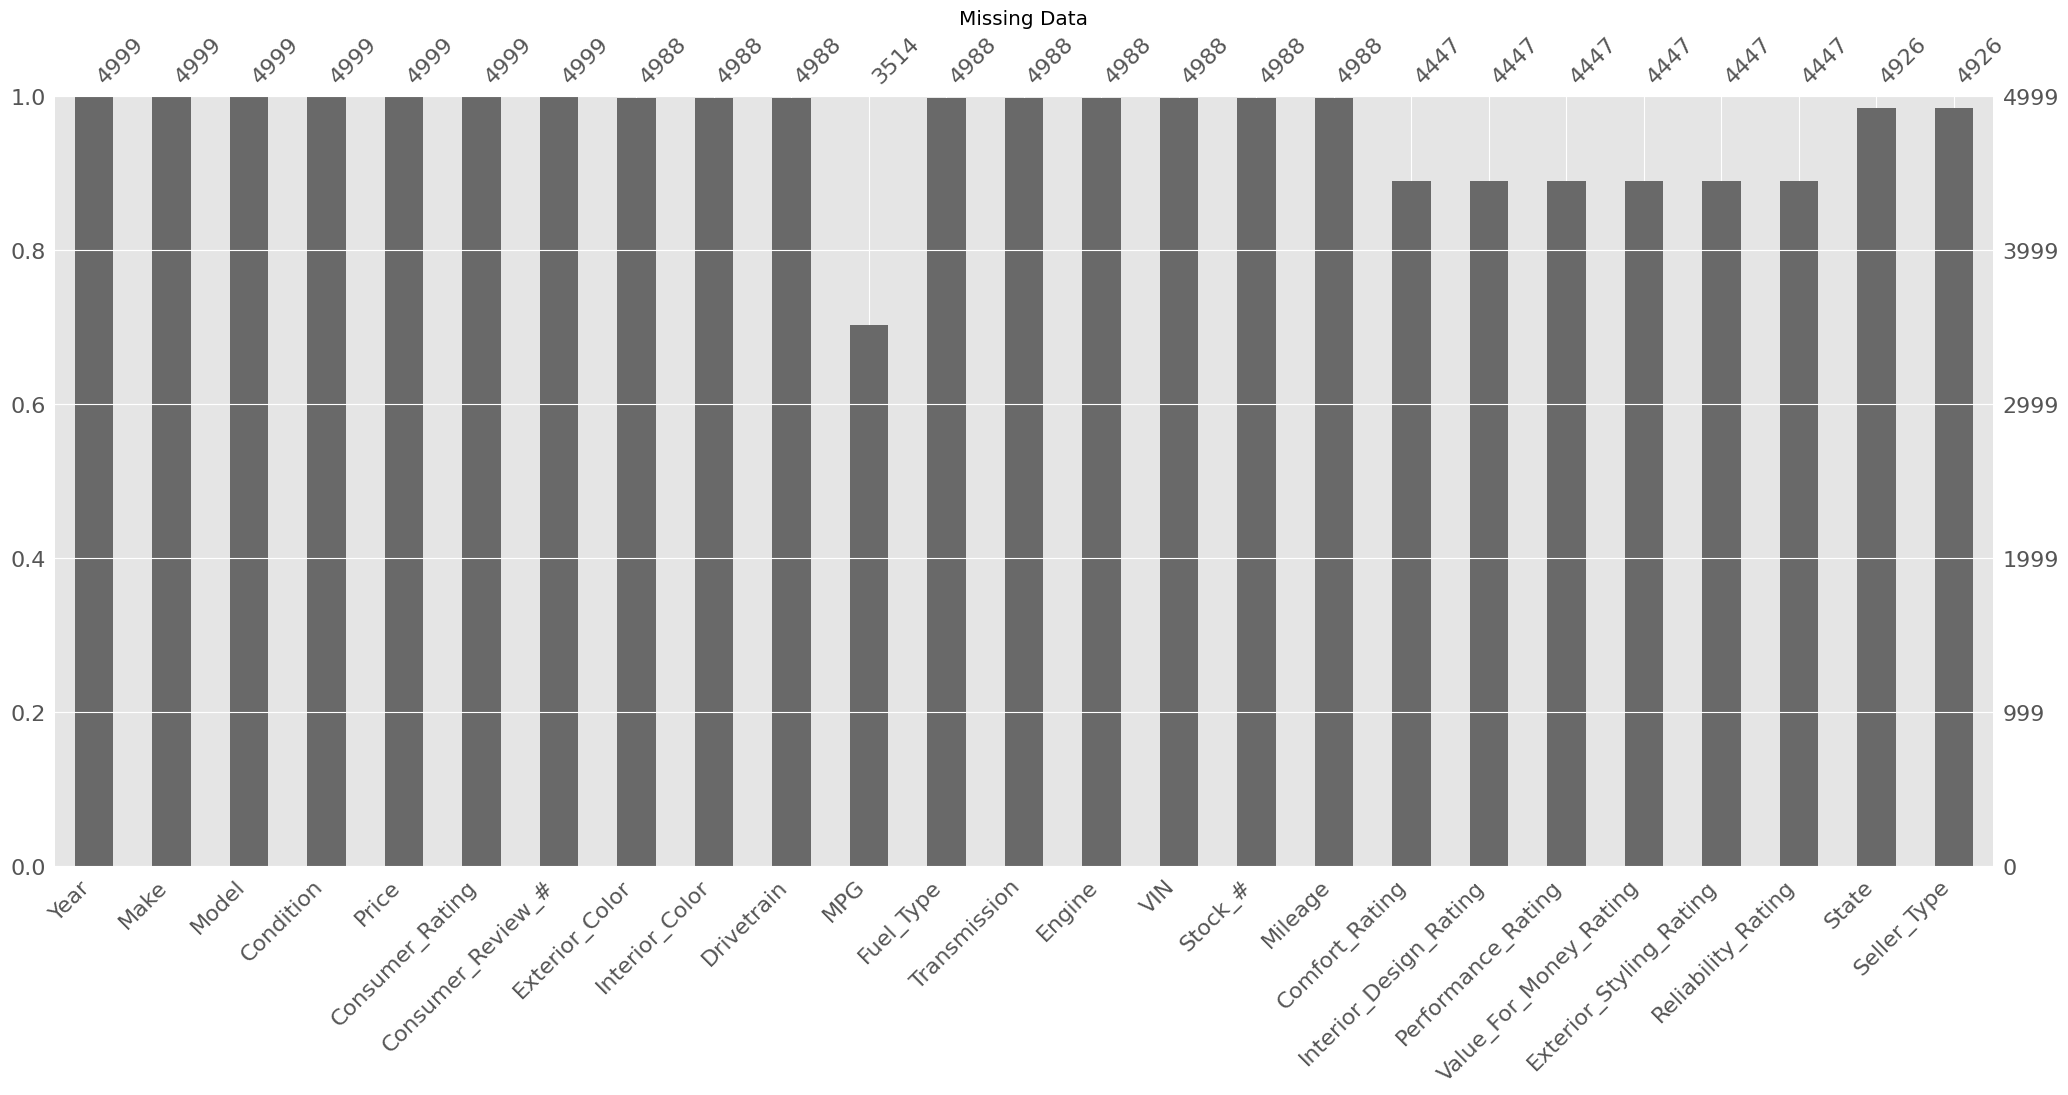

In [ ]:
# Visualize the missing data in each column
msno.bar(df)
plt.title('Missing Data')
plt.show()

In [ ]:
# Formatting the MPG and taking the median from the interval
df.MPG = df.MPG.apply(lambda x: np.median([float(i) for i in x.split('–')]) if isinstance(x, str) else x)

#Fill the missing with mean of MPG
mean_mpg = df[df.MPG.isnull() ==False]['MPG'].mean()
df.MPG = df.MPG.fillna(mean_mpg)

In [ ]:
# Convert the rating columns to numeric types
rating_cols = ['Reliability_Rating', 'Exterior_Styling_Rating', 'Value_For_Money_Rating', 'Performance_Rating', 'Interior_Design_Rating', 'Comfort_Rating']
for col in rating_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill the missing values in the rating columns with the mean value
df[rating_cols] = df[rating_cols].fillna(df[rating_cols].mean())

In [ ]:
# Fill it with "Dealer" 
df.Seller_Type = df.Seller_Type.fillna("Dealer")

# Fill it with the most data presented which is 'CA'
df.State = df.State.fillna(df.State.value_counts().index[0])

# Fill it with the most data presented which is 'Front-wheel Drive'
df.Drivetrain = df.Drivetrain.fillna(df.Drivetrain.value_counts().index[0])

# Fix data type and format
df.Mileage = df.Mileage.replace('–','0')
# drop row that contain mileage that is not int and it also dropping row that have missing values on columns Mileage,
# Stock_# ,VIN .Engine. Fuel_Type. Transmission. Interior_Color. Exterior_Color
df = df[df.Mileage.str.isdigit() == True]

# change the datatype to int
df.Mileage = df.Mileage[df.Mileage.isnull()==False].astype(int)
# fill it with '0'
df.Mileage = df.Mileage.fillna(0)
df.isnull().sum()

<ipython-input-122-e05288d0f9d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Mileage = df.Mileage[df.Mileage.isnull()==False].astype(int)
<ipython-input-122-e05288d0f9d5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Mileage = df.Mileage.fillna(0)


Year                       0
Make                       0
Model                      0
Condition                  0
Price                      0
Consumer_Rating            0
Consumer_Review_#          0
Exterior_Color             0
Interior_Color             0
Drivetrain                 0
MPG                        0
Fuel_Type                  0
Transmission               0
Engine                     0
VIN                        0
Stock_#                    0
Mileage                    0
Comfort_Rating             0
Interior_Design_Rating     0
Performance_Rating         0
Value_For_Money_Rating     0
Exterior_Styling_Rating    0
Reliability_Rating         0
State                      0
Seller_Type                0
dtype: int64

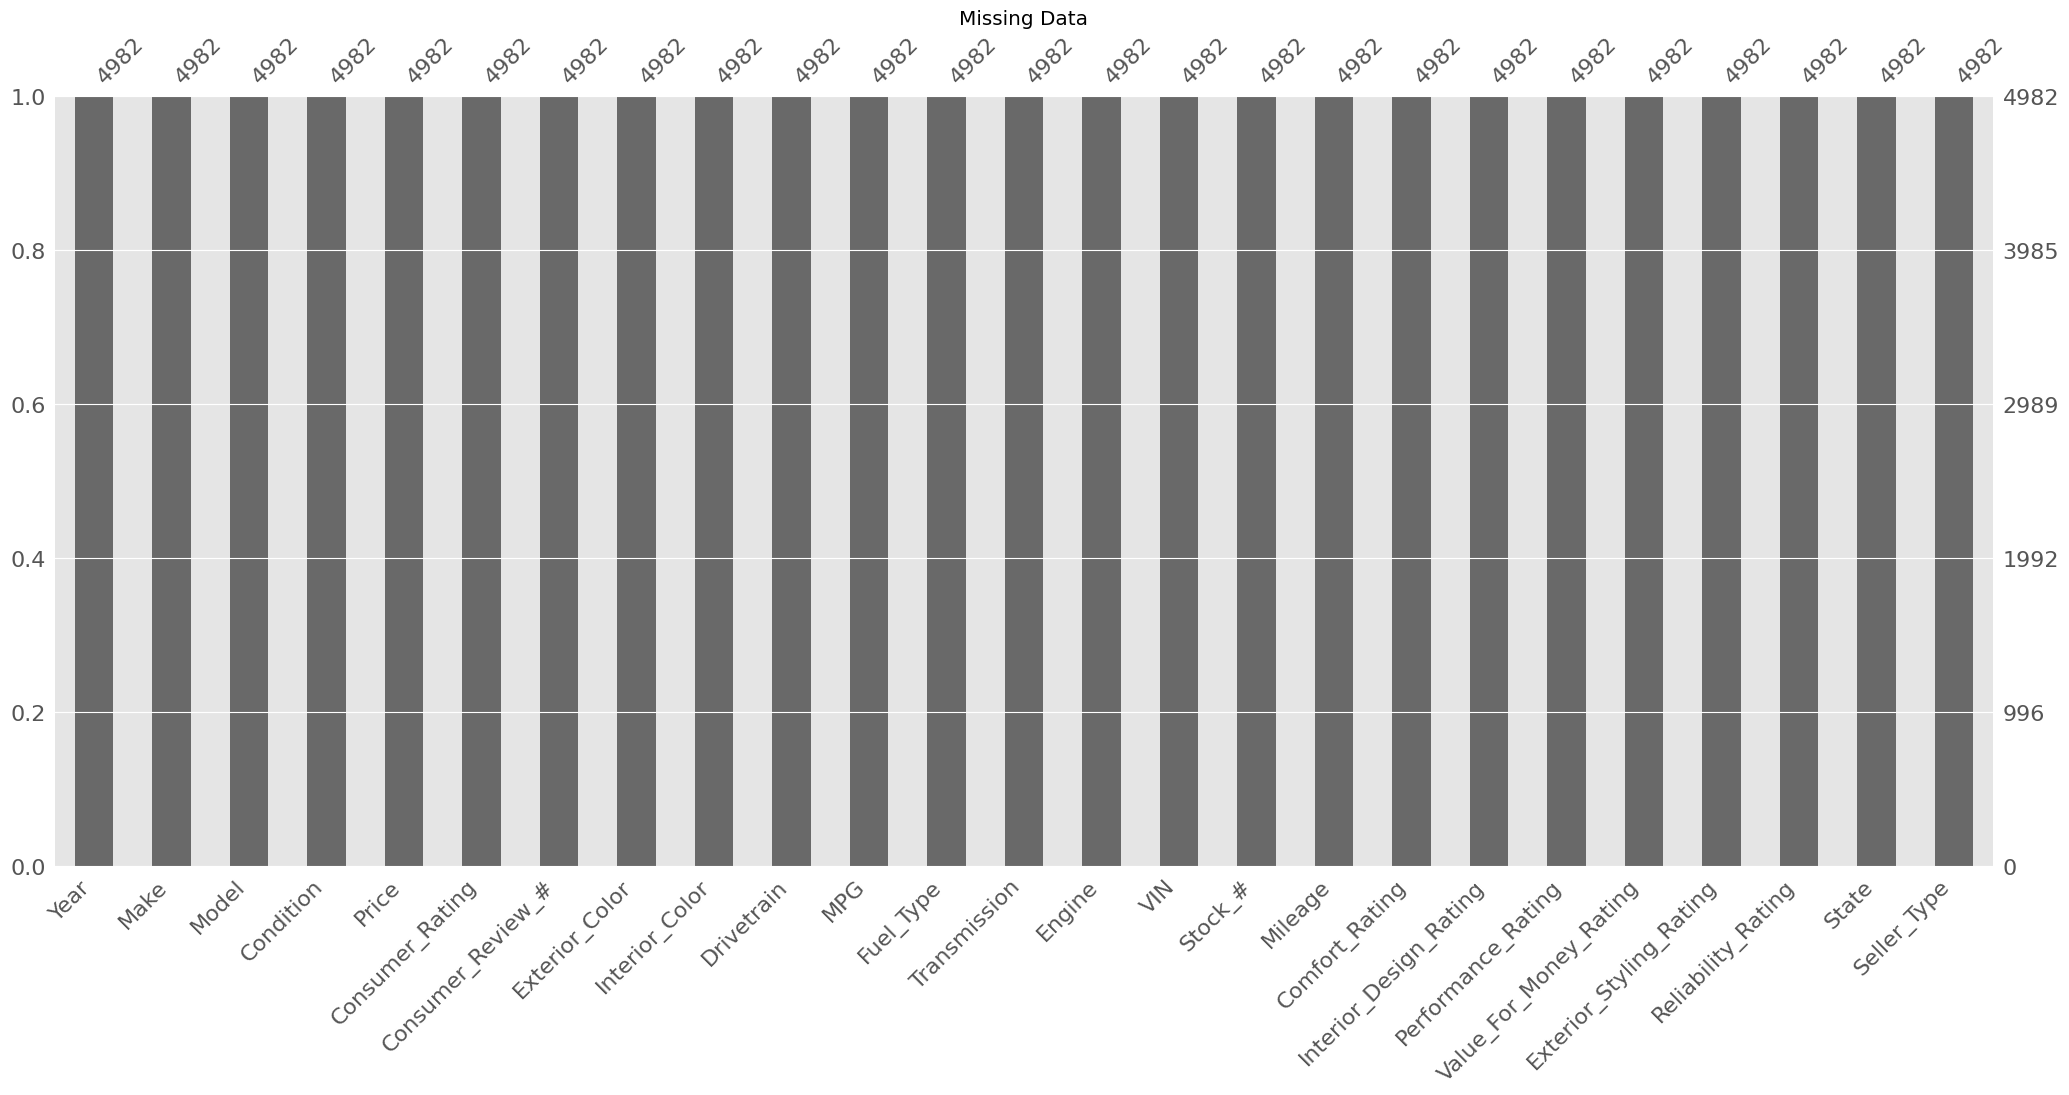

In [ ]:
# Visualize the missing data in each column
msno.bar(df)
plt.title('Missing Data')
plt.show()

<ipython-input-124-270e77b40510>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

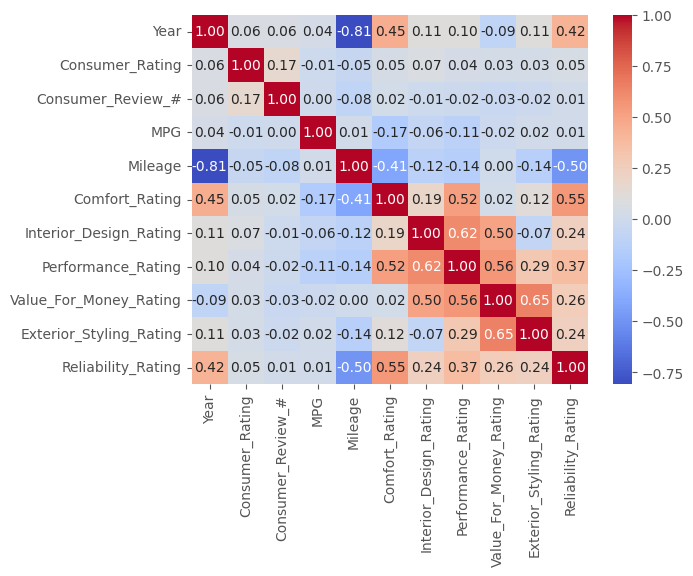

In [ ]:
# create a correlation matrix
corr_matrix = df.corr()

# plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f')


<Axes: xlabel='Price', ylabel='Count'>

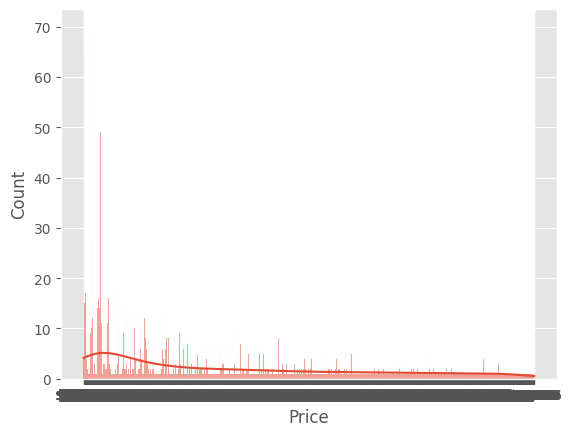

In [ ]:
# plot the price frequency
sns.histplot(data=df, x="Price", kde=True)

In [ ]:
# drop unwanted columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4982 entries, 0 to 4998
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     4982 non-null   int64  
 1   Make                     4982 non-null   object 
 2   Model                    4982 non-null   object 
 3   Condition                4982 non-null   object 
 4   Price                    4982 non-null   object 
 5   Consumer_Rating          4982 non-null   float64
 6   Consumer_Review_#        4982 non-null   int64  
 7   Exterior_Color           4982 non-null   object 
 8   Interior_Color           4982 non-null   object 
 9   Drivetrain               4982 non-null   object 
 10  MPG                      4982 non-null   float64
 11  Fuel_Type                4982 non-null   object 
 12  Transmission             4982 non-null   object 
 13  Engine                   4982 non-null   object 
 14  VIN                     

In [ ]:
#'VIN' and 'Stock_#' may not be relevant for predicting the price of a car, so we could drop those columns
df = df.drop(['VIN', 'Stock_#'], axis=1)

In [ ]:
# conver the price to numerical value
df = df[df['Price'] != 'Not Priced']
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').astype(float)


<ipython-input-128-6b2da5ed6242>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').astype(float)
<ipython-input-128-6b2da5ed6242>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').astype(float)


In [ ]:
# categorical columns 
cat_cols = ['Make', 'Seller_Type', 'Engine', 'State', 'Transmission', 'Fuel_Type', 'Interior_Color', 'Exterior_Color', 'Condition', 'Model', 'Drivetrain']

# apply label encoding to categorical columns
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])


In [ ]:
# prepare for training
# Splitting into train and test sets
X = df.drop('Price', axis=1)
y = df['Price']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **1. Linear Regression**

In [ ]:
# create a LinearRegression object and fit the model on the training data
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the target variable for the testing data
y_pred = lr.predict(X_test)


# evaluate the model using the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

# Compute the cross-validated scores for the linear regression model
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-scores)

# Print the mean and standard deviation of the RMSE scores
print("Mean RMSE: ", rmse_scores.mean())
print("Std RMSE: ", rmse_scores.std())


Mean Squared Error: 17342620.902740985
R^2 Score: 0.8498536318402781
Mean RMSE:  4152.372686662512
Std RMSE:  231.09840511548927


# **2. SVM**

In [ ]:
# Create an instance of the SVR class
svr = SVR()

# Fit the model on the training data
svr.fit(X_train, y_train)

# Predict the price of cars using the trained model
y_pred = svr.predict(X_test)

# Calculate the R-squared score and RMSE
print("R-squared score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Compute the cross-validated scores for the linear svr model
scores = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-scores)

# Print the mean and standard deviation of the RMSE scores
print("Mean RMSE: ", rmse_scores.mean())
print("Std RMSE: ", rmse_scores.std())


R-squared score: 0.06244686115442011
RMSE: 10406.337230652367
Mean RMSE:  10247.345193074525
Std RMSE:  288.25511799154145


# **3. Gradient Boosting Regressor**

In [ ]:
# create a Gradient Boosting Regressor object
gb = GradientBoostingRegressor(random_state=42)

# train the model on the training data
gb.fit(X_train, y_train)

# make predictions on the testing data
y_pred = gb.predict(X_test)

# evaluate the model
print('R-squared score:', r2_score(y_test, y_pred))

# Compute the cross-validated scores for the linear regression model
scores = cross_val_score(gb, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-scores)

# Print the mean and standard deviation of the RMSE scores
print("Mean RMSE: ", rmse_scores.mean())
print("Std RMSE: ", rmse_scores.std())


R-squared score: 0.9494102299391621
Mean RMSE:  2530.8994176488072
Std RMSE:  131.91341062399007


# **4. Random Forest Regressor**

In [ ]:
# Create the Random Forest Regressor object
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest Regressor model on the training data
rf_reg.fit(X_train, y_train)

# Predict the price of cars using the trained model
y_pred = rf_reg.predict(X_test)

# Calculate the R-squared score and RMSE
print("R-squared score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Compute the cross-validated scores for the linear regression model
scores = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-scores)

# Print the mean and standard deviation of the RMSE scores
print("Mean RMSE: ", rmse_scores.mean())
print("Std RMSE: ", rmse_scores.std())


R-squared score: 0.96153438090717
RMSE: 2107.833550519004
Mean RMSE:  2115.3811682673863
Std RMSE:  185.9270023682614
